# Trading Strategy Backtesting: MACD vs. MACD+RSI on TESLA

Objective: This notebook implements and evaluates two algorithmic trading strategies based on common technical indicators, using historical data for TESLA (TSLA) stock. The primary goal is to quantitatively compare the performance of a strategy solely relying on the Moving Average Convergence Divergence (MACD) indicator against a refined strategy that incorporates the Relative Strength Index (RSI) as an additional filter.



# 1. Install Libraries.
* **backtrader** for backtesting strategies,
* **yfinance** to download historical stock data,
* **mplfinance** for financial charting.



In [1]:
!pip install backtrader
!pip install yfinance
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


# 2. Import Libraries and Initiate the Feature Engineering Functions.



In [2]:
import pandas as pd
import yfinance as yf
import backtrader as bt
import datetime
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def download_stock_data(tickers):
    """
    Downloads stock data using yfinance and reshapes it from wide to long format.

    Returns:
        pd.DataFrame: DataFrame with columns ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
    """
    data = yf.download(tickers)
    if data.empty:
        raise ValueError(f"No data found for ticker(s): {tickers}. Check the ticker symbols and date range.")

    # Reshape from wide (multi-index) to long format and rename columns for clarity
    df = data.stack(level=1, future_stack=True).reset_index()
    df.rename(columns={'level_0': 'Date', 'level_1': 'Ticker'}, inplace=True)

    df = df.sort_values(by='Date').reset_index(drop=True)
    return df[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']]

def compute_macd_vectorized(df, n_fast=12, n_slow=26, n_signal=9):
    """
    Computes MACD indicators in a vectorized manner for each ticker.

    Parameters:
        df (pd.DataFrame): DataFrame containing stock data with a 'Close' column.
        n_fast (int): EMA period for the fast moving average.
        n_slow (int): EMA period for the slow moving average.
        n_signal (int): EMA period for the signal line.

    Returns:
        pd.DataFrame: DataFrame with additional columns:
                      'EMA_fast', 'EMA_slow', 'MACD', 'MACD_signal', and 'MACD_hist'.
    """
    df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

    # Calculate the fast and slow EMAs for the 'Close' price for each ticker
    df['EMA_fast'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=n_fast, adjust=False).mean())
    df['EMA_slow'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=n_slow, adjust=False).mean())

    # Compute MACD line and signal line
    df['MACD'] = df['EMA_fast'] - df['EMA_slow']
    df['MACD_signal'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=n_signal, adjust=False).mean())

    # MACD histogram is the difference between the MACD and its signal line
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']

    return df

def compute_rsi_vectorized_wilder(df, period=14):
    """
    Computes RSI indicator using Wilder's Smoothing method in a vectorized manner for each ticker.

    Parameters:
        df (pd.DataFrame): DataFrame containing stock data with 'Ticker' and 'Close' columns.
                           Assumed to be sorted by Ticker and Date.
        period (int): The lookback period for the RSI calculation (Wilder's N).

    Returns:
        pd.DataFrame: DataFrame with an additional 'RSI' column.
    """
    df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

    # Calculate price change
    delta = df.groupby('Ticker')['Close'].diff()

    # Separate gains (up) and losses (down)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0) # Loss is positive

    # Calculate the Wilder Smoothing span
    wilder_span = 2 * period - 1

    # Calculate the Exponential Moving Average (equivalent to Wilder's Smoothing)
    avg_gain = gain.groupby(df['Ticker']).transform(lambda x: x.ewm(span=wilder_span, adjust=False).mean())
    avg_loss = loss.groupby(df['Ticker']).transform(lambda x: x.ewm(span=wilder_span, adjust=False).mean())

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss.replace(0, pd.NA) # Avoid division by zero, replace 0 loss with NA

    # Calculate RSI
    rsi = 100.0 - (100.0 / (1.0 + rs))

    df['RSI'] = rsi

    return df

def generate_trade_signal(df):
    """
    Generates trading signals based on MACD crossover logic.

    A buy signal (1) is generated when MACD crosses above MACD_signal,
    while a sell signal (-1) is generated when MACD crosses below MACD_signal.
    Otherwise, the signal remains 0 (no action).

    Returns:
        pd.DataFrame: The input DataFrame with an additional column 'trade_signal'.
    """
    df = df.copy()

    # Define buy condition: use shift to get previous row's values
    buy_cond = (df['MACD'].shift(1) > df['MACD_signal'].shift(1)) & (df['MACD'].shift(2) <= df['MACD_signal'].shift(2))

    # Define sell condition similarly.
    sell_cond = (df['MACD'].shift(1) < df['MACD_signal'].shift(1)) & (df['MACD'].shift(2) >= df['MACD_signal'].shift(2))

    # Use np.where to assign: 1 for buy, -1 for sell, 0 otherwise.
    df['trade_signal'] = np.where(buy_cond, 1, np.where(sell_cond, -1, 0))

    return df

def generate_trade_signal_macd_rsi(df, rsi_oversold=30, rsi_overbought=70):
    """
    Generates trading signals based on MACD crossover confirmed by RSI levels.

    - A buy signal (1) is generated when:
        - MACD crosses above MACD_signal (on the previous day)
        - AND RSI (on the previous day) is below the overbought threshold.
    - A sell signal (-1) is generated when:
        - MACD crosses below MACD_signal (on the previous day)
        - AND RSI (on the previous day) is above the oversold threshold.
    - Otherwise, the signal remains 0 (no action).

    Parameters:
        df (pd.DataFrame): DataFrame containing Ticker, Date, MACD, MACD_signal, and RSI columns.
                           MUST be sorted by Ticker and then Date.
        rsi_oversold (int): The RSI level below which the asset is considered oversold.
        rsi_overbought (int): The RSI level above which the asset is considered overbought.

    Returns:
        pd.DataFrame: The input DataFrame with an additional column 'trade_signal_2'.
    """

    df = df.copy()


    # --- Define Conditions ---

    # Condition 1: MACD crossed above Signal line between t-2 and t-1
    macd_crossed_up = (df['MACD'].shift(1) > df['MACD_signal'].shift(1)) & \
                      (df['MACD'].shift(2) <= df['MACD_signal'].shift(2))

    # Condition 2: MACD crossed below Signal line between t-2 and t-1
    macd_crossed_down = (df['MACD'].shift(1) < df['MACD_signal'].shift(1)) & \
                        (df['MACD'].shift(2) >= df['MACD_signal'].shift(2))

    # Condition 3: RSI was NOT overbought at t-1
    rsi_not_overbought = (df['RSI'].shift(1) < rsi_overbought)

    # Condition 4: RSI was NOT oversold at t-1
    rsi_not_oversold = (df['RSI'].shift(1) > rsi_oversold)

    # --- Combine conditions for Buy/Sell ---

    # Buy condition: MACD crossed up AND RSI not overbought
    buy_cond = macd_crossed_up & rsi_not_overbought

    # Sell condition: MACD crossed down AND RSI not oversold
    sell_cond = macd_crossed_down & rsi_not_oversold

    # --- Assign Signals ---
    # Use np.select for clearer multi-conditional assignment
    conditions = [buy_cond, sell_cond]
    choices = [1, -1] # 1 for buy, -1 for sell
    df['trade_signal_2'] = np.select(conditions, choices, default=0) # 0 otherwise

    return df

def generate_chart(df, start_date, end_date):
    """
    Generates trading signals based on MACD crossover logic.

    A buy signal (1) is generated when MACD crosses above MACD_signal,
    while a sell signal (-1) is generated when MACD crosses below MACD_signal.
    Otherwise, the signal remains 0 (no action).

    Returns:
        pd.DataFrame: The input DataFrame with an additional column 'trade_signal'.
    """
    df = df.copy()

    # Filter the date
    df = df[(df.index >= start_date) & (df.index < end_date)].copy()

    # For buy/sell markers
    df['Buy_Signal'] = np.where(df['trade_signal'] == 1, df['Low'] * 0.95, np.nan)
    df['Sell_Signal'] = np.where(df['trade_signal'] == -1, df['High'] * 1.05, np.nan)

    # Define the Plots for MACD indicators.
    apds = [
        mpf.make_addplot(df['MACD'], panel=2, color='blue', width=1, secondary_y=False),
        mpf.make_addplot(df['MACD_signal'], panel=2, color='orange', width=1, ylabel='MACD', secondary_y=False),
        mpf.make_addplot(df['MACD_hist'], panel=2, type='bar', color='grey', alpha=0.5),
        mpf.make_addplot(df['Buy_Signal'], panel=0, type='scatter', markersize=100, marker='^', color='green'),
        mpf.make_addplot(df['Sell_Signal'], panel=0, type='scatter', markersize=100, marker='v', color='red')
    ]

    # Plot the candlestick chart with volume in the upper panel and MACD in a lower panel.
    mpf.plot(
        df,
        type='candle',
        style='charles',
        volume=True,
        addplot=apds,
        title='TSLA Candlestick Chart with MACD and Trade Signals',
        panel_ratios=(3, 1),  # Adjust the ratio between the candlestick and MACD panels
        figsize=(12, 8)
    )

class PandasDataWithSignal(bt.feeds.PandasData):
    """
    Extend the default PandasData feed to include a 'trade_signal' column.
    """
    lines = ('signal',)
    params = (('signal', 'trade_signal'),)  # The column in the DataFrame

# 3. Analyze TESLA Stock
*   Download and prepare the stock price data.
*   Generate trade signals based on the MACD strategy and MACD with RSI strategy.
*   Display 3 latest entries and exits in candlestick chart.


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Generating chart from 2024-10-20 to 2024-12-04


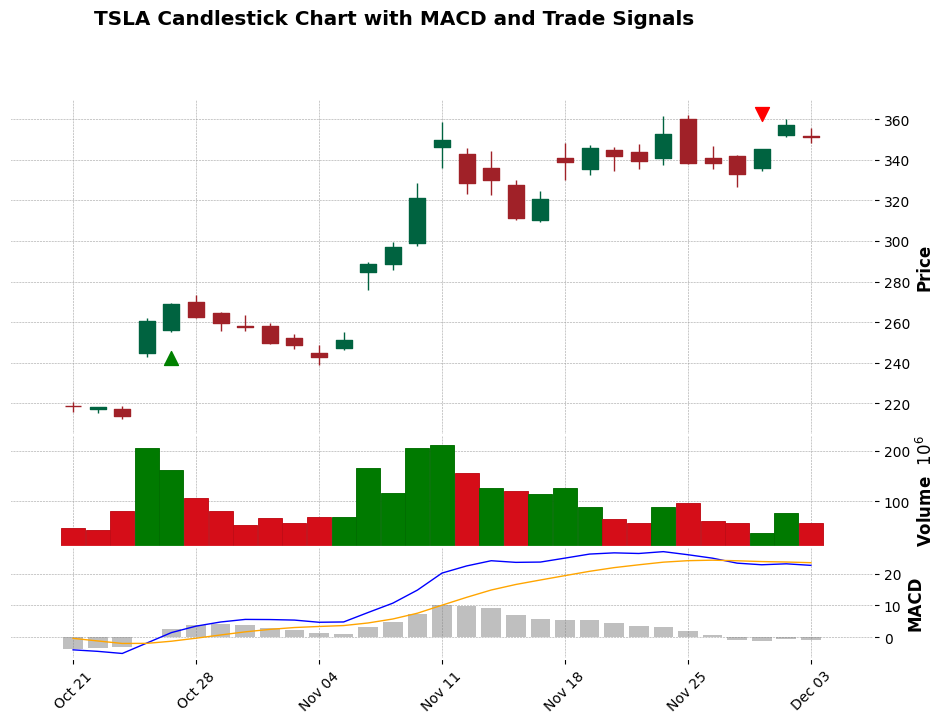


Generating chart from 2024-12-04 to 2024-12-29


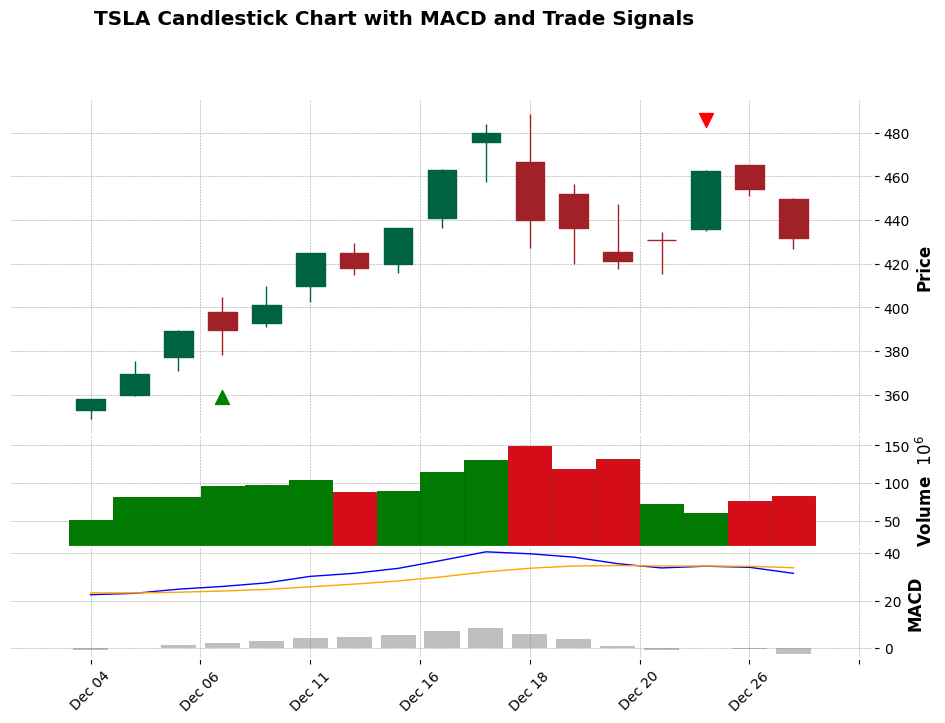


Generating chart from 2025-03-16 to 2025-04-14


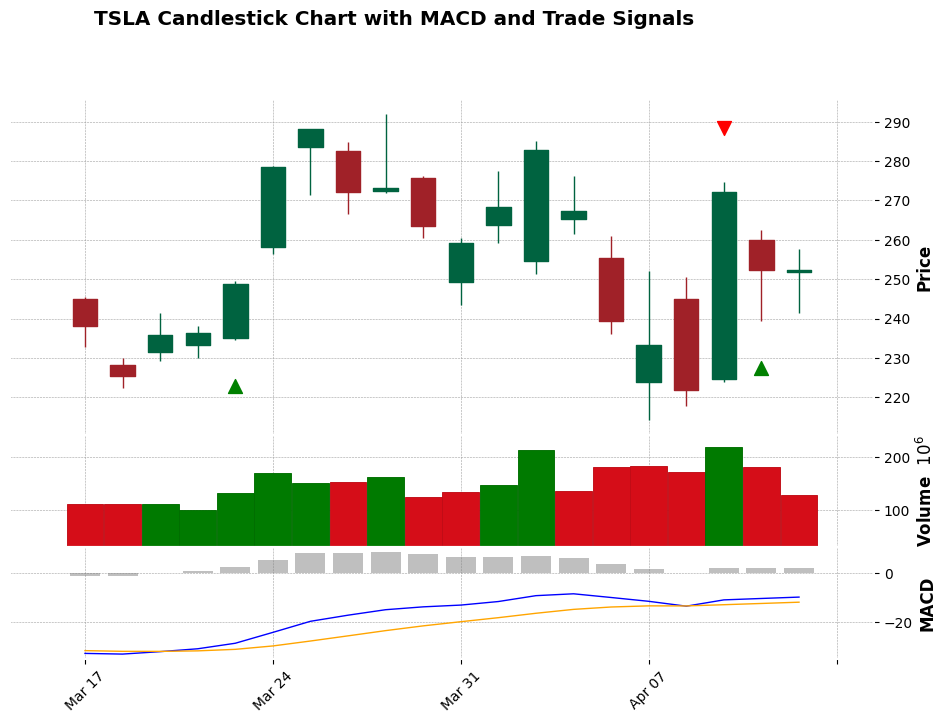


No subsequent row for trade starting at 2025-04-05. Skipping.


In [3]:
tickers = ["TSLA"]

# Download, calculate MACD, and generate trade signals
stock_df = download_stock_data(tickers)
macd_df = compute_macd_vectorized(stock_df)
macd_df = compute_rsi_vectorized_wilder(macd_df)
macd_signals_df = generate_trade_signal(macd_df)
macd_signals_df = generate_trade_signal_macd_rsi(macd_signals_df, rsi_oversold=40, rsi_overbought=60) # Another strategy with RSI

macd_signals_df['Date'] = pd.to_datetime(macd_signals_df['Date'])
macd_signals_df.set_index('Date', inplace=True)

# Show the last 3 trades of MACD strategy in chart
df_has_trade = macd_signals_df[macd_signals_df.trade_signal != 0]
buy_signals = df_has_trade[df_has_trade['trade_signal'] == 1].tail(4)

# Loop through each buy signal row and use the next row as the sell signal date.
for idx in buy_signals.index:
    # Get the integer location of the buy row in the DataFrame index
    loc = df_has_trade.index.get_loc(idx)

    # Use the buy signal's date and subtract 5 days for the start_date
    start_date = (idx - pd.Timedelta(days=5)).strftime('%Y-%m-%d')

    try:
        # Get the next row's index as the sell date and add 5 days for the end_date
        end_date = (df_has_trade.index[loc + 1] + pd.Timedelta(days=5)).strftime('%Y-%m-%d')
    except IndexError:
        print(f"No subsequent row for trade starting at {start_date}. Skipping.")
        continue

    print(f"Generating chart from {start_date} to {end_date}")

    # Call your generate_chart function with the determined start_date and end_date
    generate_chart(macd_signals_df, start_date, end_date)

    print()

# 4. Writing the Strategy Class with Backtrader
* This strategy uses all available cash to buy stock on each buy signal.

In [4]:
class All_Cash_Strategy(bt.Strategy):
    params = dict(printlog=False, cash_buffer_perc=0.99) # Use 99% of cash for buying to leave buffer

    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()} - {txt}')

    def __init__(self):
        self.order = None # To keep track of pending orders

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return # Nothing to do

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}, Size: {order.executed.size}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}, Size: {order.executed.size}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'Order Canceled/Margin/Rejected: Status {order.getstatusname()}')

        self.order = None # Reset order variable

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')

    def next(self):
        # Check if an order is pending
        if self.order:
            return

        signal = self.data.signal[0] # Get signal from precomputed data feed
        price = self.data.open[0] # Price for execution on the current bar's open, to avoid look-ahead bias

        # --- Buy Logic ---
        if not self.position and signal == 1:
            cash = self.broker.get_cash()
            commission_info = self.broker.getcommissioninfo(self.data)
            investable_cash = cash * self.params.cash_buffer_perc # Use 99% of cash

            if price > 0: # Avoid division by zero errors
                size = int(investable_cash / price) # Calculate max whole shares
                self.log(f'Attempting Buy ALL IN: Cash={cash:.2f}, Price={price:.2f}, Buffer={self.params.cash_buffer_perc*100:.1f}%, Calc Size={size}', doprint=True) # Turn doprint=True for debugging sizing

                if size > 0:
                     self.log(f'BUY CREATE (ALL IN), Price: {price:.2f}, Size: {size}', doprint=False) # Set doprint=True to see order creation logs
                     self.order = self.buy(size=size, price=price)
                else:
                     self.log(f'BUY SKIPPED (ALL IN) - Not enough cash ({cash:.2f}) for 1 share at {price:.2f}', doprint=True) # Log if cannot afford even 1 share
            else:
                self.log(f'BUY SKIPPED (ALL IN) - Invalid price ({price:.2f})', doprint=True)


        # --- Sell Logic ---
        elif self.position and signal == -1:
            self.log(f'SELL CREATE (Close Position), Price: {price:.2f}', doprint=False) # Set doprint=True to see order creation logs
            self.order = self.close(price=price) # Close at the open price

    def stop(self):
        final_value = self.broker.getvalue()
        self.log(f'Ending Portfolio Value: {final_value:.2f}', doprint=True)

# 4.1 Functions to Run Backtest and Get Trade Metrics


In [5]:
def run_backtest(data_df, signal_column_name, strategy_class, cash, comm, risk_free_rate):
    print(f"\n--- Running Backtest for Signal: '{signal_column_name}' ---")
    cerebro = bt.Cerebro(stdstats=False)
    datafeed = PandasDataWithSignal(dataname=data_df, signal=signal_column_name)
    cerebro.adddata(datafeed)
    cerebro.addstrategy(strategy_class, printlog=False)
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=comm)

    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe_analyzer',
                        timeframe=bt.TimeFrame.Days, riskfreerate=risk_free_rate)

    print(f'Starting Portfolio Value: {cash:.2f}')
    results = cerebro.run()
    final_value = cerebro.broker.getvalue()
    print(f'Final Portfolio Value:  {final_value:.2f}')
    print("-" * (len(signal_column_name) + 30))
    return results

def extract_strategy_metrics(strategy, initial_cash, annual_risk_free_rate):
    """
    Extracts key performance metrics from a Backtrader strategy's analyzers.

    Args:
        strategy (bt.Strategy): The strategy instance obtained from cerebro.run()[0].
        initial_cash (float): The starting cash for the backtest.
        annual_risk_free_rate (float): The risk-free rate used for Sharpe calculation.

    Returns:
        dict: A dictionary containing the performance metrics.
    """
    metrics = {}
    final_value = strategy.broker.getvalue()

    # Basic Performance
    metrics['Final Value'] = final_value
    metrics['Net PnL'] = final_value - initial_cash
    metrics['Total Return (%)'] = ((final_value / initial_cash) - 1) * 100

    # --- Extract from Analyzers ---
    try:
        trade_stats = strategy.analyzers.trade_analyzer.get_analysis()
        metrics['Total Trades'] = trade_stats.total.total
        metrics['Winning Trades'] = trade_stats.won.total
        metrics['Losing Trades'] = trade_stats.lost.total
        if trade_stats.total.total > 0:
            metrics['Win Rate (%)'] = (trade_stats.won.total / trade_stats.total.total) * 100
            metrics['Avg Win PnL'] = trade_stats.won.pnl.average
            metrics['Avg Loss PnL'] = trade_stats.lost.pnl.average
            # Handle division by zero for Profit Factor
            if trade_stats.lost.pnl.total != 0:
                metrics['Profit Factor'] = abs(trade_stats.won.pnl.total / trade_stats.lost.pnl.total)
            else:
                metrics['Profit Factor'] = np.inf # Use infinity if no losses
            metrics['Max Consecutive Wins'] = trade_stats.streak.won.longest
            metrics['Max Consecutive Losses'] = trade_stats.streak.lost.longest
        else:
             # Assign defaults if no trades occurred
             metrics['Win Rate (%)'] = 0.0
             metrics['Avg Win PnL'] = 0.0
             metrics['Avg Loss PnL'] = 0.0
             metrics['Profit Factor'] = np.nan
             metrics['Max Consecutive Wins'] = 0
             metrics['Max Consecutive Losses'] = 0
    except AttributeError:
        print(f"Warning: TradeAnalyzer results not found for strategy {strategy.__class__.__name__}.")
        metrics.update({k: np.nan for k in ['Total Trades', 'Winning Trades', 'Losing Trades',
                                            'Win Rate (%)', 'Avg Win PnL', 'Avg Loss PnL',
                                            'Profit Factor', 'Max Consecutive Wins',
                                            'Max Consecutive Losses']})

    try:
        drawdown_stats = strategy.analyzers.drawdown.get_analysis()
        metrics['Max Drawdown (%)'] = drawdown_stats.max.drawdown
        metrics['Max Drawdown Bars'] = drawdown_stats.max.len
    except AttributeError:
        print(f"Warning: DrawDown analyzer results not found for strategy {strategy.__class__.__name__}.")
        metrics['Max Drawdown (%)'] = np.nan
        metrics['Max Drawdown Bars'] = np.nan

    try:
        sharpe_stats = strategy.analyzers.sharpe_analyzer.get_analysis()
        metrics[f'Annualized Sharpe (Rf={annual_risk_free_rate*100:.1f}%)'] = sharpe_stats.get('sharperatio')
    except AttributeError:
        print(f"Warning: SharpeRatio_A analyzer results not found for strategy {strategy.__class__.__name__}.")
        metrics[f'Annualized Sharpe (Rf={annual_risk_free_rate*100:.1f}%)'] = np.nan

    try:
        sqn_stats = strategy.analyzers.sqn.get_analysis()
        metrics['SQN'] = sqn_stats.get('sqn')
    except AttributeError:
        print(f"Warning: SQN analyzer results not found for strategy {strategy.__class__.__name__}.")
        metrics['SQN'] = np.nan

    return metrics

# 5. Run the Backtesting for Strategies and Benchmark.

In [6]:
start_dt = datetime.datetime(2020, 1, 1)
end_dt = datetime.datetime(2025, 4, 1)
initial_cash = 100000.0
annual_risk_free_rate = 0.02
commission_rate = 0.001
backtest_data_df = macd_signals_df[(macd_signals_df.index >= start_dt) & (macd_signals_df.index < end_dt)].copy()

# --- Run Backtests ---
# MACD strategy with trade_signal column
results_strategy1 = run_backtest(
    data_df=backtest_data_df,
    signal_column_name='trade_signal',
    strategy_class=All_Cash_Strategy,
    cash=initial_cash,
    comm=commission_rate,
    risk_free_rate=annual_risk_free_rate
)

# MACD + RSI strategy with trade_signal_2 column
results_strategy2 = run_backtest(
    data_df=backtest_data_df,
    signal_column_name='trade_signal_2',
    strategy_class=All_Cash_Strategy,
    cash=initial_cash,
    comm=commission_rate,
    risk_free_rate=annual_risk_free_rate
)

# --- Extract Metrics and Compare ---
print("\n--- Performance Comparison ---")
strategy1_instance = results_strategy1[0]
strategy2_instance = results_strategy2[0]
metrics1 = extract_strategy_metrics(strategy1_instance, initial_cash, annual_risk_free_rate)
metrics2 = extract_strategy_metrics(strategy2_instance, initial_cash, annual_risk_free_rate)
comparison_df = pd.DataFrame({
    'MACD_Only': metrics1,
    'MACD_RSI': metrics2
})

# --- Add Buy & Hold Benchmark ---
bh_data = backtest_data_df['Close']
first_close = bh_data.iloc[0]
last_close = bh_data.iloc[-1]
bh_return = ((last_close / first_close) - 1) * 100
bh_final_value = initial_cash * (1 + bh_return / 100)

# Add B&H column - Pad with NaN for metrics not applicable to B&H
comparison_df['Buy_Hold'] = pd.Series(dtype='object') # Initialize column
comparison_df.loc['Final Value', 'Buy_Hold'] = bh_final_value
comparison_df.loc['Net PnL', 'Buy_Hold'] = bh_final_value - initial_cash
comparison_df.loc['Total Return (%)', 'Buy_Hold'] = bh_return


--- Running Backtest for Signal: 'trade_signal' ---
Starting Portfolio Value: 100000.00
2020-03-30 - Attempting Buy ALL IN: Cash=100000.00, Price=34.02, Buffer=99.0%, Calc Size=2910
2020-06-03 - Attempting Buy ALL IN: Cash=155834.82, Price=59.21, Buffer=99.0%, Calc Size=2605
2020-07-02 - Attempting Buy ALL IN: Cash=173725.15, Price=81.43, Buffer=99.0%, Calc Size=2112
2020-08-18 - Attempting Buy ALL IN: Cash=173725.15, Price=126.60, Buffer=99.0%, Calc Size=1358
2020-10-14 - Attempting Buy ALL IN: Cash=165971.15, Price=149.93, Buffer=99.0%, Calc Size=1095
2020-11-09 - Attempting Buy ALL IN: Cash=155574.84, Price=146.50, Buffer=99.0%, Calc Size=1051
2020-11-18 - Attempting Buy ALL IN: Cash=153516.60, Price=149.45, Buffer=99.0%, Calc Size=1016
2020-12-18 - Attempting Buy ALL IN: Cash=153516.60, Price=222.97, Buffer=99.0%, Calc Size=681
2021-01-05 - Attempting Buy ALL IN: Cash=147941.65, Price=241.22, Buffer=99.0%, Calc Size=607
2021-03-15 - Attempting Buy ALL IN: Cash=147941.65, Price=231

# 6. Generate Plots of
* Equity curve of MACD strategy and MACD + RSI strategy
* Equity curve of strategies vs benchmark (buy & hold strategy)
* Drawdown

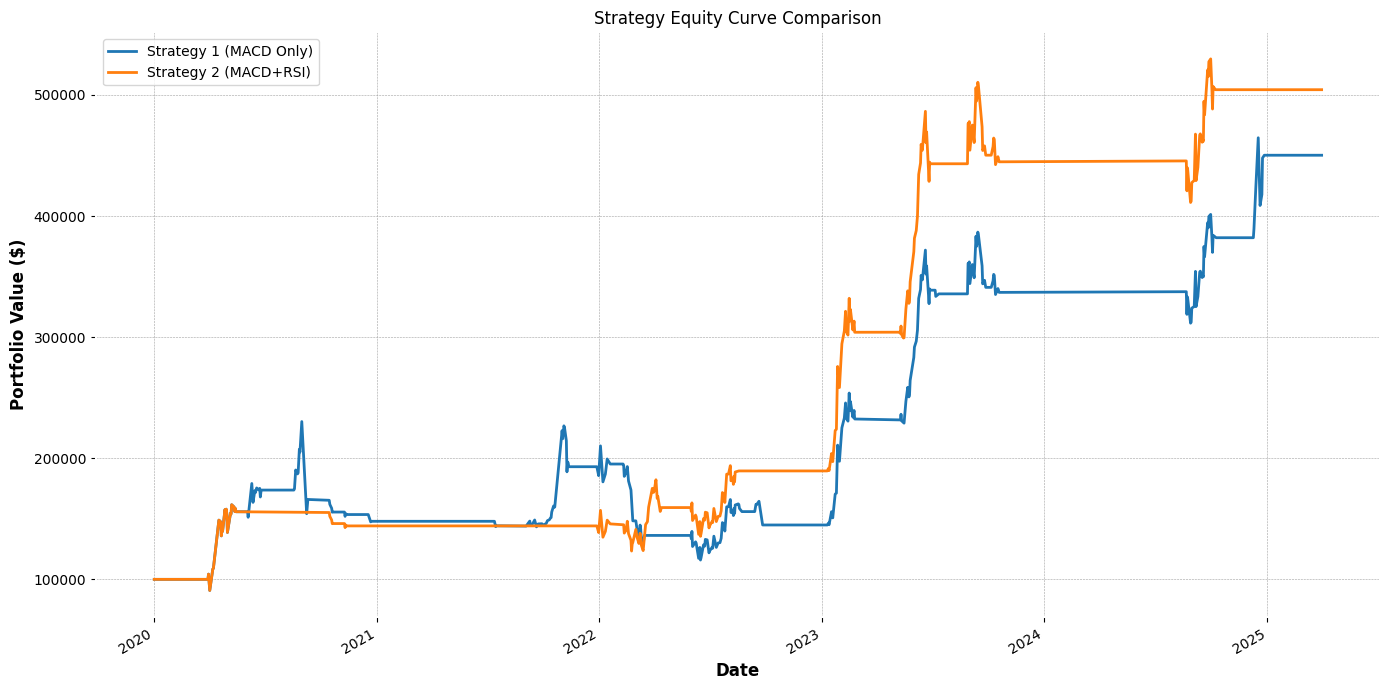

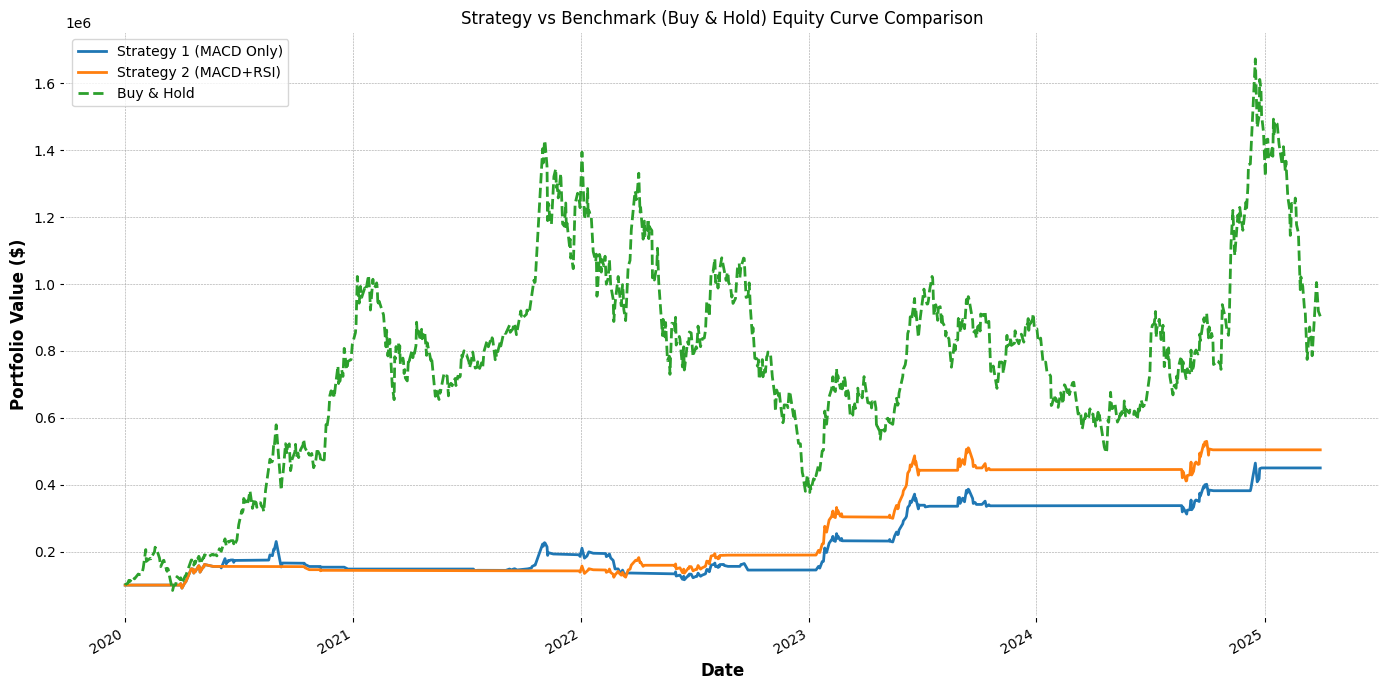

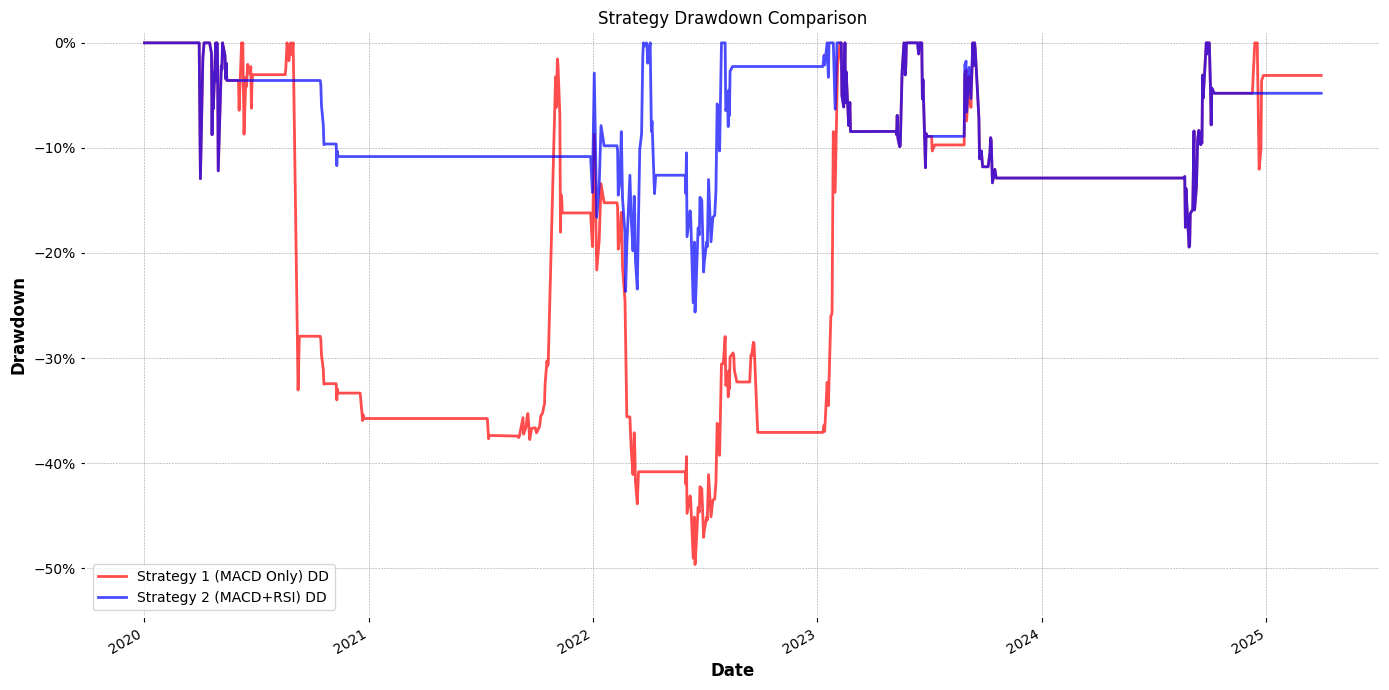

In [8]:
# --- Extract TimeReturn Data for Both Strategies ---
portfolio_values1 = strategy1_instance.analyzers.timereturn.get_analysis()
portfolio_values2 = strategy2_instance.analyzers.timereturn.get_analysis()

# --- Calculate Equity Curves ---
returns_df1 = pd.DataFrame(list(portfolio_values1.items()), columns=['Date', 'Returns']).set_index('Date')
equity_curve1 = (1 + returns_df1['Returns']).cumprod() * initial_cash
equity_curve1.name = 'Strategy 1 (MACD Only)'

returns_df2 = pd.DataFrame(list(portfolio_values2.items()), columns=['Date', 'Returns']).set_index('Date')
equity_curve2 = (1 + returns_df2['Returns']).cumprod() * initial_cash
equity_curve2.name = 'Strategy 2 (MACD+RSI)'

# --- Plot Combined Equity Curves (Strategy 1, Strategy 2) ---
plt.figure(figsize=(14, 7))
equity_curve1.plot(legend=True)
equity_curve2.plot(legend=True)
plt.title('Strategy Equity Curve Comparison')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print()

# --- Plot Combined Equity Curves (Strategy 1, Strategy 2, Benchmark) ---
plt.figure(figsize=(14, 7))
equity_curve1.plot(legend=True)
equity_curve2.plot(legend=True)

# Plot Buy & Hold Benchmark
bh_close_series = backtest_data_df['Close']
first_close = bh_close_series.iloc[0]
bh_equity = (bh_close_series / first_close) * initial_cash
bh_label = 'Buy & Hold'
bh_equity.plot(label=bh_label, legend=True, linestyle='--')

plt.title('Strategy vs Benchmark (Buy & Hold) Equity Curve Comparison')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print()

# --- Calculate Drawdowns ---
peak1 = equity_curve1.cummax()
drawdown1 = (equity_curve1 - peak1) / peak1
drawdown1.name = equity_curve1.name + ' DD'
peak2 = equity_curve2.cummax()
drawdown2 = (equity_curve2 - peak2) / peak2
drawdown2.name = equity_curve2.name + ' DD'

# --- Plot Combined Drawdowns ---
plt.figure(figsize=(14, 7))
drawdown1.plot(legend=True, color='red', alpha=0.7)
drawdown2.plot(legend=True, color='blue', alpha=0.7)
plt.title('Strategy Drawdown Comparison')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.ylim(bottom=min(drawdown1.min(), drawdown2.min()) - 0.05, top=0.01)
plt.legend()
plt.tight_layout()
plt.show()

print()

In [9]:
# --- Display the comparison table ---
print(comparison_df.round(2))

                             MACD_Only   MACD_RSI       Buy_Hold
Final Value                  450213.92  504327.61  903500.221462
Net PnL                      350213.92  404327.61  803500.221462
Total Return (%)                350.21     404.33     803.500221
Total Trades                     27.00      13.00            NaN
Winning Trades                   14.00       9.00            NaN
Losing Trades                    13.00       4.00            NaN
Win Rate (%)                     51.85      69.23            NaN
Avg Win PnL                   33911.21   48540.95            NaN
Avg Loss PnL                  -9580.23   -8135.24            NaN
Profit Factor                     3.81      13.43            NaN
Max Consecutive Wins              6.00       7.00            NaN
Max Consecutive Losses            5.00       2.00            NaN
Max Drawdown (%)                 49.65      25.63            NaN
Max Drawdown Bars               611.00     472.00            NaN
Annualized Sharpe (Rf=2.0

# Summary

In short, **Strategy 2 (MACD+RSI)** is demonstrably superior to **Strategy 1 (MACD Only)**. The addition of the RSI filter appears to significantly enhance performance by improving trade selection (higher win rate, higher profit factor), increasing overall profitability, and drastically reducing portfolio volatility and maximum drawdown.

While neither active strategy matched the absolute return of the Buy & Hold benchmark during this specific backtest period, Strategy 2 offers a significantly improved risk profile. The choice between Strategy 2 and Buy & Hold would depend on the investor's tolerance for volatility and drawdown versus their objective of maximizing absolute returns.

